In [1]:
import os
import sys
from copy import deepcopy

import torch
import matplotlib.pyplot as plt
from botorch.models.transforms.input import AffineInputTransform

from lume_torch.variables import ScalarVariable
from lume_torch.models import TorchModel, TorchModule

sys.path.append("./../../../")
from calibration_modules.decoupled_linear import DecoupledLinearInput
from calibration_modules.utils import extract_input_transformer

# Set up MLflow registry
# run below for local tracking: (see https://mlflow.org/docs/latest/getting-started/intro-quickstart/)
# use whatever port is not being used
# > mlflow server --host 127.0.0.1 --port 8082 --gunicorn-opts --timeout=60
os.environ["MLFLOW_TRACKING_URI"] = (
    "http://127.0.0.1:8082"  # or whatever port you use above
)

/Users/smiskov/miniconda3/envs/lume-torch-latest/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create base model
class BaseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x) -> torch.Tensor:
        return x**2 + 0.3


base_model = BaseModel().double()

In [3]:
# create input transformers
input_sim_to_nn = AffineInputTransform(
    d=1, coefficient=torch.ones(1), offset=-0.5 * torch.ones(1)
)
input_pv_to_sim = AffineInputTransform(
    d=1, coefficient=torch.ones(1), offset=-0.5 * torch.ones(1)
)

# define in- and output variables
input_name, output_name = "InputPV", "OutputPV"
base_input_variables = {
    input_name: ScalarVariable(
        name=input_name, default_value=-1.0, value_range=[-2.0, 0.0]
    )
}
base_output_variables = {output_name: ScalarVariable(name=output_name)}

# create TorchModel
base_model_file = "tmp.pt"
torch.save(base_model, base_model_file)
lume_torch = TorchModel(
    model=base_model_file,
    input_variables=base_input_variables,
    output_variables=base_output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[],
)
os.remove(base_model_file)

# wrap in TorchModule
lume_module = TorchModule(model=lume_torch)

# Register initial model to MLflow

In [4]:
input_example = torch.linspace(
    base_input_variables[input_name].value_range[0],
    base_input_variables[input_name].value_range[1],
    10,
    dtype=torch.double,
).unsqueeze(-1)

# you can register either the TorchModel or the TorchModule
_ = lume_module.register_to_mlflow(
    "nn_prior_example_model",
    "nn_prior",
    tags={"type": "example"},
    version_tags={"state": "base"},
    save_jit=True,
)

🏃 View run bright-midge-939 at: http://127.0.0.1:8082/#/experiments/0/runs/18f2ecf660ca42c48c311d53f3adef24
🧪 View experiment at: http://127.0.0.1:8082/#/experiments/0


Successfully registered model 'nn_prior'.
Created version '1' of model 'nn_prior'.


# Create miscalibrated model

In [5]:
# create miscalibrated base model
class MiscalibratedBaseModel(torch.nn.Module):
    def __init__(self, base_model, offset=0.3):
        super().__init__()
        self.base_model = base_model
        self.offset = offset

    def forward(self, x) -> torch.Tensor:
        x = x - self.offset
        mask = (-1.0 <= x) * (x <= 1.0)
        y = torch.zeros(x.shape, dtype=x.dtype)
        y[mask] = self.base_model(x[mask])
        y[~mask] = x[~mask] * 0.0
        return y


miscalibrated_base_model = MiscalibratedBaseModel(base_model).double()

In [6]:
# define in- and output variables
miscalibrated_input_variables = {k: v for k, v in base_input_variables.items()}
for k, v in base_input_variables.items():
    v.default_value += miscalibrated_base_model.offset
    v.value_range = (
        v.value_range[0] + miscalibrated_base_model.offset,
        v.value_range[1] + miscalibrated_base_model.offset,
    )
miscalibrated_output_variables = {k: v for k, v in base_output_variables.items()}

# create TorchModel
miscalibrated_base_model_file = "tmp.pt"
torch.save(miscalibrated_base_model, miscalibrated_base_model_file)
miscalibrated_lume_torch = TorchModel(
    model=miscalibrated_base_model_file,
    input_variables=miscalibrated_input_variables,
    output_variables=miscalibrated_output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[],
)
os.remove(miscalibrated_base_model_file)

# wrap in TorchModule
miscalibrated_lume_module = TorchModule(
    model=miscalibrated_lume_torch,
)

In [7]:
# Suppress out of range warnings for the plotting
lume_module.model.input_validation_config = {"InputPV": "none"}
miscalibrated_lume_module.model.input_validation_config = {"InputPV": "none"}

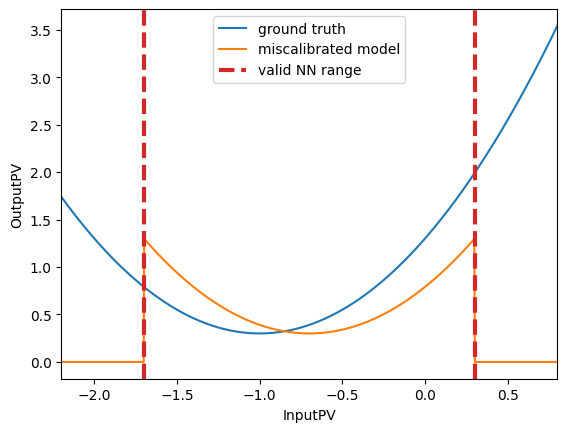

In [8]:
# compare on example data
x = torch.linspace(
    base_input_variables[input_name].value_range[0] - 0.5,
    base_input_variables[input_name].value_range[1] + 0.5,
    1000,
    dtype=torch.double,
).unsqueeze(-1)
fig, ax = plt.subplots()
ax.plot(x, lume_module(x), "C0-", label="ground truth")
ax.plot(x, miscalibrated_lume_module(x), "C1-", label="miscalibrated model")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))
ax.axvline(
    x=miscalibrated_lume_torch.input_variables[0].value_range[0],
    color="C3",
    linestyle="--",
    linewidth=3.0,
    label="valid NN range",
)
ax.axvline(
    x=miscalibrated_lume_torch.input_variables[0].value_range[1],
    color="C3",
    linestyle="--",
    linewidth=3.0,
)
ax.legend(loc="upper center");

# Register miscalibrated model to MLflow

In [9]:
input_example = torch.linspace(
    miscalibrated_input_variables[input_name].value_range[0],
    miscalibrated_input_variables[input_name].value_range[1],
    10,
    dtype=torch.double,
).unsqueeze(-1)

# you can register either the TorchModel or the TorchModule
_ = miscalibrated_lume_module.register_to_mlflow(
    "nn_prior_example_model",
    "nn_prior",
    version_tags={"state": "miscalibrated"},
    save_jit=True,
)

🏃 View run secretive-frog-358 at: http://127.0.0.1:8082/#/experiments/0/runs/881cb83a07634544a7b5de16d9b2f52c
🧪 View experiment at: http://127.0.0.1:8082/#/experiments/0


Registered model 'nn_prior' already exists. Creating a new version of this model...
Created version '2' of model 'nn_prior'.


# Retrain/recalibrate model

In [10]:
# create training data set
x_train = torch.linspace(
    *miscalibrated_input_variables[input_name].value_range, 1000, dtype=torch.double
).unsqueeze(-1)
with torch.no_grad():
    y_train = lume_module(x_train).unsqueeze(-1)

# normalize to NN units
for input_transformer in lume_torch.input_transformers:
    x_train = input_transformer(x_train)

In [11]:
# create calibration model
cal_model = DecoupledLinearInput(
    model=miscalibrated_base_model,
    x_size=len(miscalibrated_lume_torch.input_names),
)
cal_model

DecoupledLinearInput(
  (model): MiscalibratedBaseModel(
    (base_model): BaseModel()
  )
  (x_offset_prior): NormalPrior()
  (x_scale_prior): GammaPrior()
  (raw_x_scale_constraint): Positive()
)

In [12]:
# define trainable parameters
trainable_params = []
for name, param in cal_model.named_parameters():
    if param.requires_grad:
        print(name)
        trainable_params.append(getattr(cal_model, name))

raw_x_offset
raw_x_scale


In [13]:
# initial parameter values
for name, param in cal_model.named_parameters():
    if param.requires_grad and name.startswith("raw_"):
        print(f"{name[4:]}: ", getattr(cal_model, name[4:]).data)

x_offset:  tensor([0.])
x_scale:  tensor([1.])


## Train Calibration Layers

In [14]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        (
            self.x,
            self.y,
        ) = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [15]:
# define dataloader
batch_size = y_train.shape[0]
trainset = Dataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=0
)

In [16]:
# training configuration
reg = 1e-3
lr = 1e-3
n_epochs = int(5e3)
optimizer = torch.optim.Adam(trainable_params, lr=lr, weight_decay=reg)
criterion = torch.nn.L1Loss(reduction="sum")

In [17]:
%%time
# training loop
losses = []
for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
        inputs, targets = batch_data
        optimizer.zero_grad()
        outputs = cal_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i == 0:
            losses.append(loss.item())

CPU times: user 9.2 s, sys: 140 ms, total: 9.34 s
Wall time: 9.36 s


In [18]:
# parameter values after training
for name, param in cal_model.named_parameters():
    if param.requires_grad and name.startswith("raw_"):
        print(f"{name[4:]}: ", getattr(cal_model, name[4:]).data)

x_offset:  tensor([0.3001])
x_scale:  tensor([1.0000])


In [19]:
input_nn_to_cal = extract_input_transformer(cal_model)

In [20]:
# create TorchModel
miscalibrated_base_model_file = "tmp.pt"
torch.save(miscalibrated_base_model, miscalibrated_base_model_file)
calibrated_lume_torch = TorchModel(
    model=miscalibrated_base_model_file,
    input_variables=miscalibrated_lume_torch.input_variables,
    output_variables=miscalibrated_lume_torch.output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
    output_transformers=[],
)
os.remove(miscalibrated_base_model_file)

# wrap in TorchModule
calibrated_lume_module = TorchModule(
    model=calibrated_lume_torch,
)

## Training Results

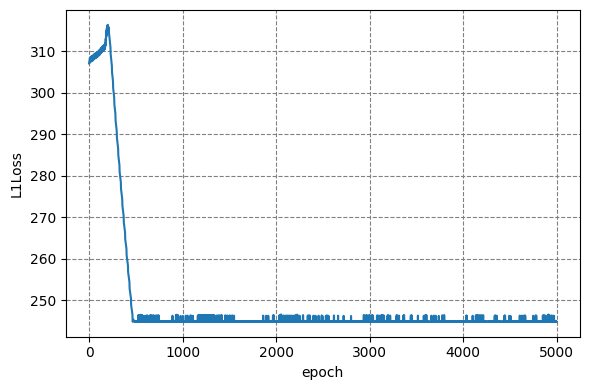

In [21]:
# plot training process
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel("epoch")
ax.plot(losses, "C0")
ax.set_ylabel(criterion.__class__.__name__)
ax.grid(color="gray", linestyle="dashed")
# ax.set_yscale("log")
fig.tight_layout()

In [22]:
# Suppress out of range warnings for the plotting
lume_module.model.input_validation_config = {"InputPV": "none"}
calibrated_lume_module.model.input_validation_config = {"InputPV": "none"}

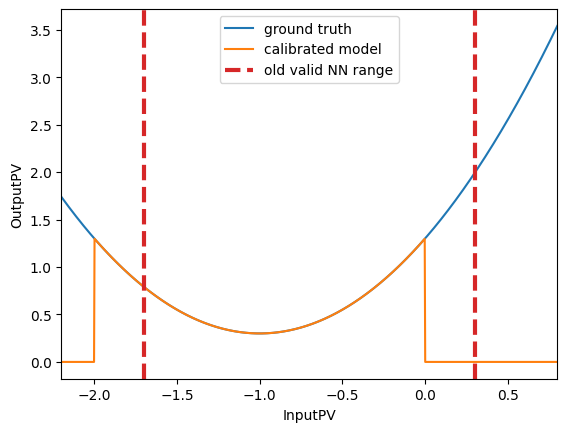

In [23]:
# compare on example data
fig, ax = plt.subplots()
ax.plot(x, lume_module(x), label="ground truth")
ax.plot(x, calibrated_lume_module(x), label="calibrated model")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))
ax.axvline(
    x=miscalibrated_lume_torch.input_variables[0].value_range[0],
    color="C3",
    linestyle="--",
    linewidth=3.0,
    label="old valid NN range",
)
ax.axvline(
    x=miscalibrated_lume_torch.input_variables[0].value_range[1],
    color="C3",
    linestyle="--",
    linewidth=3.0,
)
ax.legend(loc="upper center");

## Calculate New Valid NN Range

In [24]:
def update_input_variables_to_transformer(
    lume_torch, transformer_loc: int
) -> list[ScalarVariable]:
    """Returns input variables updated to the transformer at the given location.

    Updated are the value ranges and default of the input variables. This allows, e.g., to add a
    calibration transformer and to update the input variable specification accordingly.

    Args:
        lume_torch: The LUME-model for which the input variables shall be updated.
        transformer_loc: The location of the input transformer to adjust for.

    Returns:
        The updated input variables.
    """
    x_old = {
        "min": torch.tensor(
            [var.value_range[0] for var in lume_torch.input_variables],
            dtype=torch.double,
        ),
        "max": torch.tensor(
            [var.value_range[1] for var in lume_torch.input_variables],
            dtype=torch.double,
        ),
        "default_value": torch.tensor(
            [var.default_value for var in lume_torch.input_variables],
            dtype=torch.double,
        ),
    }
    x_new = {}
    for key in x_old.keys():
        x = x_old[key].unsqueeze(0)
        # compute previous limits at transformer location
        for i in range(transformer_loc):
            x = lume_torch.input_transformers[i].transform(x)
        # untransform of transformer to adjust for
        x = lume_torch.input_transformers[transformer_loc].untransform(x)
        # backtrack through transformers
        for transformer in lume_torch.input_transformers[:transformer_loc][::-1]:
            x = transformer.untransform(x)
        x_new[key] = x
    updated_variables = deepcopy(lume_torch.input_variables)
    for i, var in enumerate(updated_variables):
        var.value_range = [x_new["min"][i].item(), x_new["max"][i].item()]
        var.default_value = x_new["default_value"][i].item()
    return updated_variables

In [25]:
calibrated_lume_torch.input_variables

[ScalarVariable(name='InputPV', read_only=False, default_validation_config='none', default_value=-0.7, value_range=(-1.7, 0.3), unit=None)]

In [26]:
updated_input_variables = update_input_variables_to_transformer(
    calibrated_lume_torch, transformer_loc=2
)
calibrated_lume_torch.input_variables = updated_input_variables

In [27]:
calibrated_lume_torch.input_variables

[ScalarVariable(name='InputPV', read_only=False, default_validation_config='none', default_value=-1.0000732600688935, value_range=[-2.0000554978847505, -9.10222530363658e-05], unit=None)]

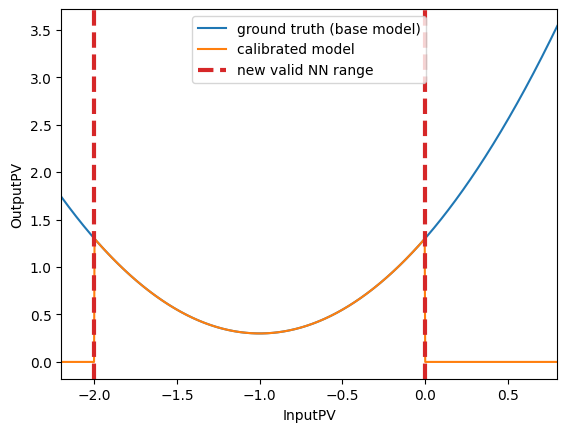

In [28]:
# compare on example data
fig, ax = plt.subplots()
ax.plot(x, lume_module(x), label="ground truth (base model)")
ax.plot(x, calibrated_lume_module(x), label="calibrated model")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))
ax.axvline(
    x=calibrated_lume_torch.input_variables[0].value_range[0],
    color="C3",
    linestyle="--",
    linewidth=3.0,
    label="new valid NN range",
)
ax.axvline(
    x=calibrated_lume_torch.input_variables[0].value_range[1],
    color="C3",
    linestyle="--",
    linewidth=3.0,
)
ax.legend(loc="upper center");

# Update calibrated model to MLflow

In [29]:
input_example = torch.linspace(
    calibrated_lume_torch.input_variables[0].value_range[0],
    calibrated_lume_torch.input_variables[0].value_range[1],
    10,
    dtype=torch.double,
).unsqueeze(-1)

# you can register either the TorchModel or the TorchModule
_ = calibrated_lume_module.register_to_mlflow(
    "nn_prior_example_model",
    "nn_prior",
    version_tags={"state": "re-calibrated"},
    save_jit=True,
)

🏃 View run vaunted-midge-61 at: http://127.0.0.1:8082/#/experiments/0/runs/bd518d7ff2304227869869ac0abd2962
🧪 View experiment at: http://127.0.0.1:8082/#/experiments/0


Registered model 'nn_prior' already exists. Creating a new version of this model...
Created version '3' of model 'nn_prior'.
/Users/smiskov/miniconda3/envs/lume-torch-latest/lib/python3.14/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [field_name='value_range', input_value=[-2.0000554978847505, -9.10222530363658e-05], input_type=list])
  return self.__pydantic_serializer__.to_python(


# Pull from MLflow and plot

In [32]:
import mlflow

base_model = mlflow.pytorch.load_model("models:/nn_prior/1")
miscalibrated_model = mlflow.pytorch.load_model("models:/nn_prior/2")
calibrated_model = mlflow.pytorch.load_model("models:/nn_prior/3")

In [33]:
base_model.model.input_validation_config = {"InputPV": "none"}
miscalibrated_model.model.input_validation_config = {"InputPV": "none"}
calibrated_model.model.input_validation_config = {"InputPV": "none"}

(-2.2, 0.8)

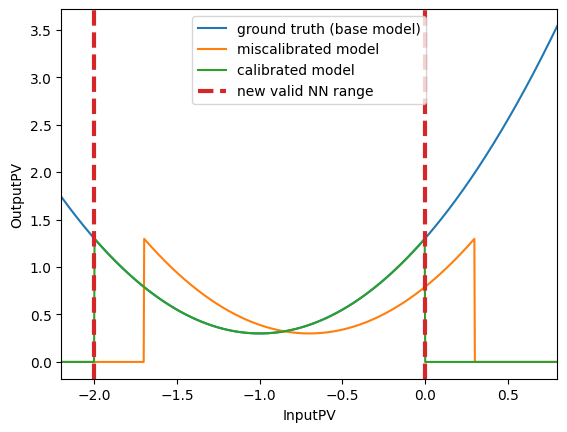

In [34]:
# compare on example data
fig, ax = plt.subplots()
ax.plot(x, base_model(x), label="ground truth (base model)")
ax.plot(x, miscalibrated_model(x), label="miscalibrated model")
ax.plot(x, calibrated_model(x), label="calibrated model")

ax.axvline(
    x=calibrated_model.model.input_variables[0].value_range[0],
    color="C3",
    linestyle="--",
    linewidth=3.0,
    label="new valid NN range",
)
ax.axvline(
    x=calibrated_model.model.input_variables[0].value_range[1],
    color="C3",
    linestyle="--",
    linewidth=3.0,
)

ax.legend(loc="upper center")
ax.set_xlabel(input_name)
ax.set_ylabel(output_name)
ax.set_xlim(torch.min(x), torch.max(x))

# What MLflow UI will look like

Under "Models", you should see the nn_prior model, and each version should have the tag we assigned. 

<img src="img/example_ui.png" style="height:600px">

In [35]:
# Clean up local MLflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

model_name = "nn_prior"

# Search for all versions of the model
all_versions = client.search_model_versions(f"name='{model_name}'")

# Iterate and delete each version
for version in all_versions:
    print(f"Deleting version {version.version} of model {model_name}")
    client.delete_model_version(name=model_name, version=version.version)

client.delete_registered_model(name=model_name)
print(f"Registered model '{model_name}' deleted.")

Deleting version 3 of model nn_prior
Deleting version 2 of model nn_prior
Deleting version 1 of model nn_prior
Registered model 'nn_prior' deleted.
